## Описание проекта

Компания по предоставлению услуг таксо-перевозок собрала исторические данные о заказах такси в аэропортах.  Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

# 1. Подготовка

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
df.index.is_monotonic

True

- Данные имеют один признак - числовой;  
- Пропусков не имеется;
- Индекс имеет тип timestamp и отсортирован по возрастанию - все значения лежат на временном отрезке от 1 марта до 31 августа 2018г.

В соотвествии с заданием сделаем ресемплирование и добавим признаки.

In [4]:
df_resample = df.resample('1H').sum()
df_resample.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [5]:
df_resample['month'] = df_resample.index.month
df_resample['day'] = df_resample.index.day
df_resample['dayofweek'] = df_resample.index.dayofweek
df_resample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 4 columns):
num_orders    4416 non-null int64
month         4416 non-null int64
day           4416 non-null int64
dayofweek     4416 non-null int64
dtypes: int64(4)
memory usage: 172.5 KB


# 2. Анализ

In [6]:
df_resample.describe(include='all')

,num_orders,month,day,dayofweek
count,4416.000000,4416.000000,4416.000000,4416.000000
mean,84.422781,5.505435,15.836957,3.005435
std,45.023853,1.713306,8.855229,1.990684
min,0.000000,3.000000,1.000000,0.000000
25%,54.000000,4.000000,8.000000,1.000000
50%,78.000000,5.500000,16.000000,3.000000
75%,107.000000,7.000000,23.250000,5.000000
max,462.000000,8.000000,31.000000,6.000000


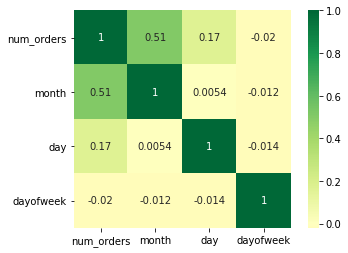

In [7]:
sns.heatmap(df_resample.corr(), cmap='RdYlGn', center=0, annot=True, square=True);

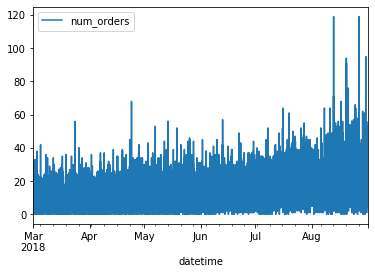

In [8]:
df.plot();

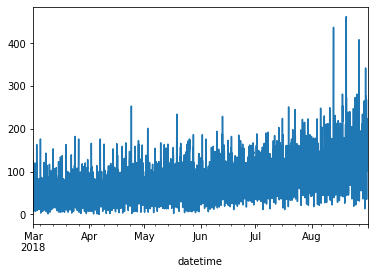

In [9]:
df_resample['num_orders'].plot();

В целом, если смотреть на диаграмму ресемплированных данных, то можно заметить, что она повторяет картинку исходных данных и монотонно возрастает от 1 марта до 31 августа.  
Ее вполне можно аппроксимировать полиномами первой или второй степени. Но в нашу задачу это не входит. 

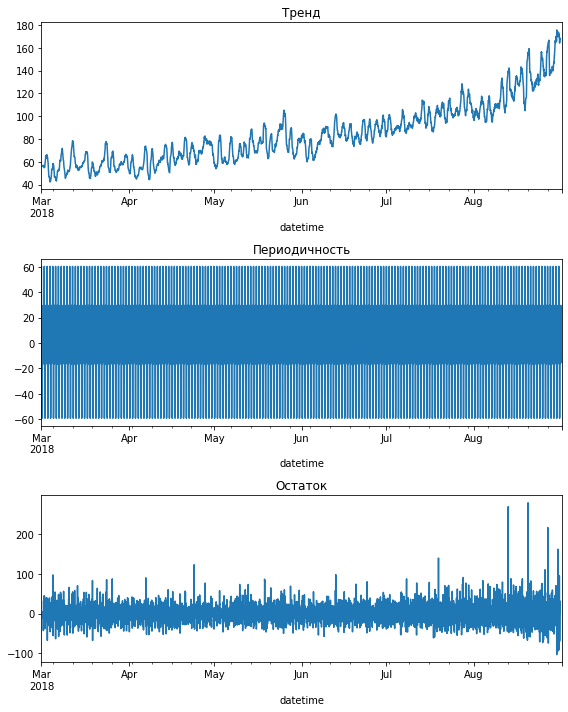

In [10]:
# Анализ на тренды и периодичность

decomposed = seasonal_decompose(df_resample['num_orders'])

plt.figure(figsize=(8, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Периодичность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

Как ранее и говорилось, данные имеют некую тенденцию к монотонному возрастанию (имеют тренд).  
Причем к концу лета количество заказов такси больше, чем в начале весны почти в 3 раза, а то и поболее.  

Также имеется четкая периодичная составляющая. При таком масштабе ее не особо можно увидеть, поэтому сделаем масштаб более крупный - выведем данные за три дня.

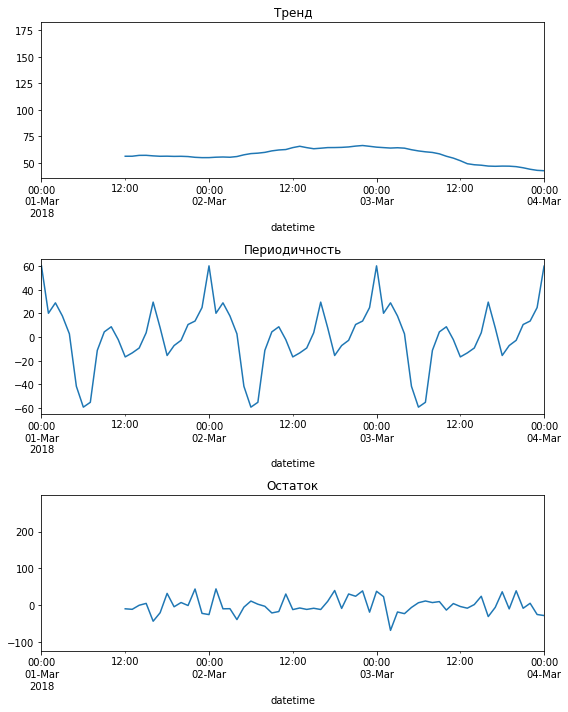

In [11]:
plt.figure(figsize=(8, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), xlim=('2018-03-01 00:00:00', '2018-03-04 00:00:00'))
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), xlim=('2018-03-01 00:00:00', '2018-03-04 00:00:00'))
plt.title('Периодичность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), xlim=('2018-03-01 00:00:00', '2018-03-04 00:00:00'))
plt.title('Остаток')
plt.tight_layout()

Теперь четко видно, что изо дня в день повторяется одна и таже картина - пик заказов приходится на время в районе полночи, а также есть 2 пика связанных с деловыми поездками - это в районе 11:00 и 15:00 часов.
***

# 3. Обучение

In [12]:
def make_features(max_lag, rolling_mean_size):
    data = pd.DataFrame(df_resample.values, columns=df_resample.columns)
    for lag in range(1, max_lag):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

def fit_model(lags, rolling_size):
    data = make_features(lags, rolling_size)
    train, test = train_test_split(data, shuffle=False, test_size=0.2)
    train = train.dropna()
    target = train['num_orders']
    train = train.drop('num_orders', axis=1)
    target_test = test['num_orders']
    test = test.drop('num_orders', axis=1)

    model = LinearRegression()
    model.fit(train, target)
    rmse_train = mean_squared_error(model.predict(train), target)**0.5
    rmse_test = mean_squared_error(model.predict(test), target_test)**0.5
    return rmse_train, rmse_test


In [13]:
%%time
scores = []
for lags in range(1, 10):
    for rolling_size in range(1, 20):
        rmse_train, rmse_test = fit_model(lags, rolling_size)
        scores.append(['lags{}-rolling_size{}'.format(lags, rolling_size), rmse_train, rmse_test])


CPU times: user 9.66 s, sys: 17.1 s, total: 26.8 s
Wall time: 26.8 s


In [14]:
scores = pd.DataFrame(scores, columns=['labels', 'rmse_train', 'rmse_test'])
scores['diff'] = scores['rmse_test'] - scores['rmse_train']
scores.head()

,labels,rmse_train,rmse_test,diff
0,lags1-rolling_size1,29.288848,47.573608,18.284760
1,lags1-rolling_size2,29.929628,49.291960,19.362332
2,lags1-rolling_size3,30.922612,51.829245,20.906632
3,lags1-rolling_size4,31.643787,53.426366,21.782579
4,lags1-rolling_size5,32.051219,54.357066,22.305847


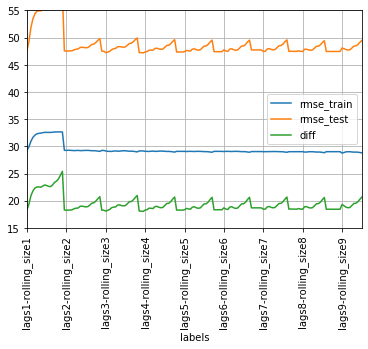

In [15]:
scores.plot(x='labels', ylim=(15, 55), grid=True, rot=90);

In [16]:
# сортировка метрик по возрастанию, выбор модели с наилучшими параметрами
scores.sort_values('rmse_test').head()

,labels,rmse_train,rmse_test,diff
59,lags4-rolling_size3,29.162782,47.193279,18.030497
58,lags4-rolling_size2,29.160114,47.254345,18.094230
40,lags3-rolling_size3,29.160114,47.254345,18.094230
57,lags4-rolling_size1,29.160114,47.254345,18.094230
41,lags3-rolling_size4,29.089189,47.328265,18.239076


# 4. Тестирование

In [17]:
# лучшая модель
best_score = scores.sort_values('rmse_test').iloc[0]
best_params = {'lags': int((best_score.iloc[0].split('-')[0]).split('lags')[-1]), 
               'rolling_size': int(best_score.iloc[0].split('rolling_size')[-1])
              }
print('Параметры лучшей модели:', best_params)
print()

Параметры лучшей модели: {'lags': 4, 'rolling_size': 3}



RMSE_train: 29.16278179073042
RMSE_test: 47.19327910062754


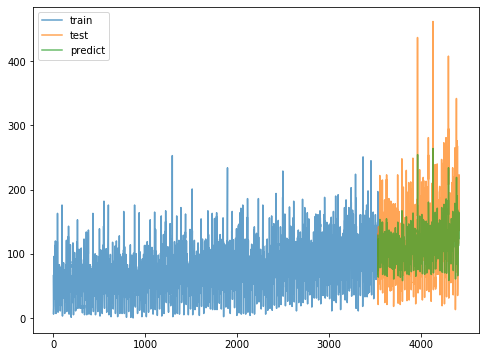

In [18]:
data = make_features(best_params['lags'], best_params['rolling_size'])
train, test = train_test_split(data, shuffle=False, test_size=0.2)
train = train.dropna()
target = train['num_orders']
train = train.drop('num_orders', axis=1)
target_test = test['num_orders']
test = test.drop('num_orders', axis=1)

model = LinearRegression()
model.fit(train, target)
y_predict = model.predict(test)

rmse_train = mean_squared_error(model.predict(train), target)**0.5
rmse_test = mean_squared_error(y_predict, target_test)**0.5
print ("RMSE_train:", rmse_train)
print ("RMSE_test:", rmse_test)

plt.figure(figsize=(8, 6))
plt.plot(train.index, target, alpha=0.7, label='train')
plt.plot(test.index, target_test, alpha=0.7, label='test')
plt.plot(test.index, y_predict, alpha=0.7, label='predict')
plt.legend();


Для сравнения построим модель только для признака 'num_orders'. Т.е. как в изначальной таблице df_resample, без дополнительных признаков year, month и проч. Получаем простую линейную аппроксимацию.

RMSE_train: 32.68716311624413
RMSE_test: 57.020758908425435


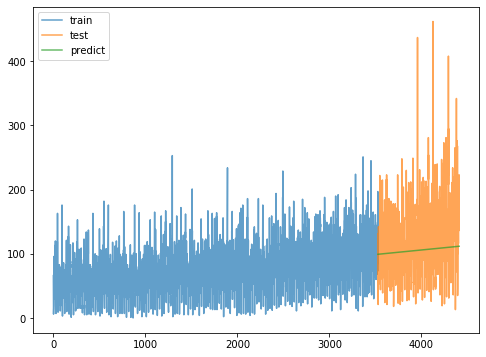

In [19]:
train2 = [i for i in range(len(train))]
train2 = np.reshape(train2, (-1, 1))
test2 = [j for j in range(len(train), len(train)+len(test))]
test2 = np.reshape(test2, (-1, 1))
model2 = LinearRegression()
model2.fit(train2, target)
y_predict = model2.predict(test2)

rmse_train = mean_squared_error(model2.predict(train2), target)**0.5
rmse_test = mean_squared_error(y_predict, target_test)**0.5
print ("RMSE_train:", rmse_train)
print ("RMSE_test:", rmse_test)

plt.figure(figsize=(8, 6))
plt.plot(train2, target, alpha=0.7, label='train')
plt.plot(test2, target_test, alpha=0.7, label='test')
plt.plot(test2, y_predict, alpha=0.7, label='predict')
plt.legend();


Таким образом, можно сделать вывод, что при обычной аппроксимацией полиномом первого или второго порядка значение метрики rmse будет значительно больше, чем при применении линейной регрессии с дополнительными признаками, в том числе - календарные, отстающие и скользящее среднее.  
